In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pricing_models import DiscountRateCalibrator2, ClosedFormPricingModel
from forecast_models import ExponentialDecayForecast

In [4]:
# df_raw = pd.read_csv('./data/royalty_exchange_deals_revenues.csv')
# columns = df_raw.columns

# # Extracting the deals data
# columns = columns[-10:]
# df_deals = df_raw[list(columns)].copy()

# df_deals.rename(columns={
#     'years_remaining': 'years_remaining',
#     'LTM.1': 'LTM',
#     'age.1': 'age',
#     'market_median.1': 'market_median',
#     'name.2': 'name',
#     'ID.1': 'ID',
#     'type.1': 'type',
#     'multiplier.1': 'multiplier'
# }, inplace=True)

# df_deals.drop_duplicates(inplace=True)

# df_life = df_deals[df_deals['type'] == 'Life of Rights'].copy()
# df_30year = df_deals[df_deals['type'] == '30-Year'].copy()
# df_10year = df_deals[df_deals['type'] == '10-Year'].copy()

# # drop deals with age less than 2 years
# df_life = df_life[df_life['age'] >= 2]
# df_30year = df_30year[df_30year['age'] >= 2]
# df_10year = df_10year[df_10year['age'] >= 2]

In [2]:
df = pd.read_csv('./data/revenues_and_deals.csv')

deal_columns = df.columns[3:]
df_deals = df[deal_columns].copy()
df_deals.drop_duplicates(inplace=True)
df_life = df_deals[df_deals['type'] == 'Life of Rights'].copy()
# Drop deals with age less than 2 years

df_life = df_life[df_life['age'] >= 2]
df_life.reset_index(drop=True, inplace=True)

df_life.head()

,year_deal,month_deal,price,LTM,multiplier,age,ID,index,name,type,years_remaining
0,2024,5,16000,3300,4.85,2.06,5788,3605,"Petty Too"" by Lil Durk - Songwriter Royalties""",Life of Rights,70.0
1,2024,7,24800,4277,5.80,2.31,5788,3606,"Petty Too"" by Lil Durk - Songwriter Royalties""",Life of Rights,70.0
2,2024,11,130000,25126,5.17,3.97,5782,2584,"Demi Lovato, Ella Mai, Camila Cabello + More -...",Life of Rights,70.0
3,2024,11,10000,1478,6.77,4.20,5778,2464,"DaBaby, Jeremih, Justin Beiber and More Pop an...",Life of Rights,70.0
4,2024,11,30000,3873,7.75,5.22,5774,2430,"Rod Wave, Mozzy, Chris Brown + more - Songwrit...",Life of Rights,70.0


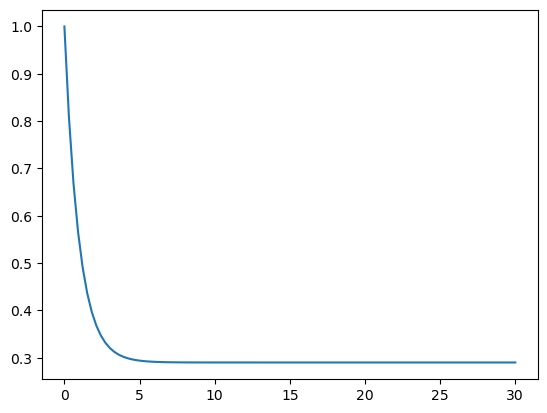

In [85]:
a = .71
b = .26 * 4
c = 1 - a
suffix = '30'


# a = .54
# b = .18 * 4
# c = 1 - a
# suffix = '50'

# a = .09
# b = .27 * 4
# c = 1 - a
# suffix = '70'

def decay_rate_func(x):
    return a * np.exp(-b * x) + c

x = np.linspace(0, 30, 100)
y = decay_rate_func(x)

plt.plot(x, y)

### Closed Form

In [86]:
from tqdm import tqdm
exp_forecastor = ExponentialDecayForecast(a, b, c)
discount_rate_calibrator = DiscountRateCalibrator2(df_life, exp_forecastor, plot=True)
df_life2 = df_life.copy()
for idx in tqdm(range(len(df_life2)), desc='Computing multipliers'):
    entry = df_life2.iloc[idx].copy()
    cashflow_table = exp_forecastor.forecast(entry)
    rate = discount_rate_calibrator.rate(entry['age'], aggregation_method='median')
    # calculate the price of the deal
    closed_form = ClosedFormPricingModel(
        discount_rate=rate,
        LTM=entry['LTM'],
        age = entry['age'],
        param = (a, b, c)

    )
    price = closed_form.price()
    multiplier = price / entry['LTM']
    df_life2.loc[idx, 'model_multiplier'] = multiplier

Calibrating discount rates:   0%|          | 0/265 [00:00<?, ?it/s]

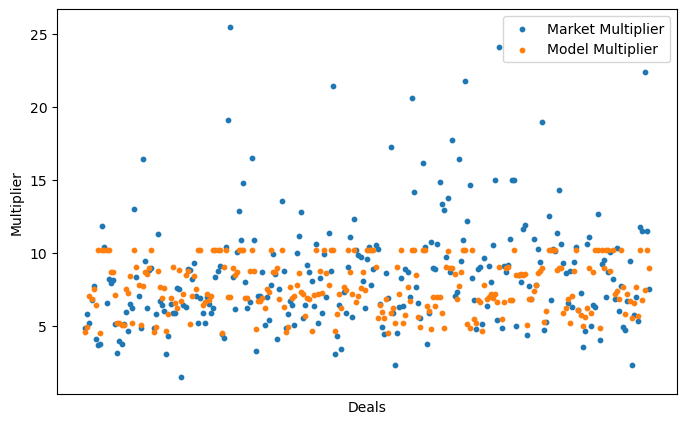

In [79]:
x = np.arange(len(df_life2))
plt.figure(figsize=(8, 5))
plt.scatter(x, df_life2['multiplier'], label='Market Multiplier', s=10)
plt.tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=False) # labels along the bottom edge are off
plt.scatter(x, df_life2['model_multiplier'], label='Model Multiplier', s=10)
plt.xlabel('Deals')
plt.ylabel('Multiplier')
plt.legend()
plt.savefig(f'./writeup/deals_multipliers_{suffix}.png', dpi=300)

In [80]:
mse = np.mean((df_life2['multiplier'] - df_life2['model_multiplier'])**2)
print(mse)

12.838404509826276


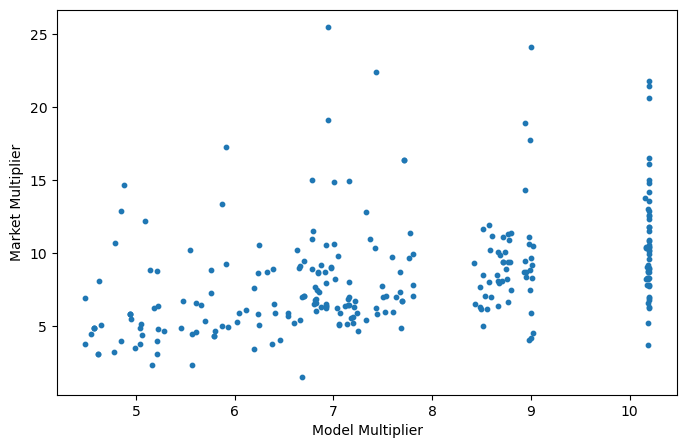

In [81]:
plt.figure(figsize=(8, 5))
plt.scatter(df_life2['model_multiplier'], df_life2['multiplier'], s=10)
plt.xlabel('Model Multiplier')
plt.ylabel('Market Multiplier')
plt.savefig(f'./writeup/model_market_{suffix}.png', dpi=300)

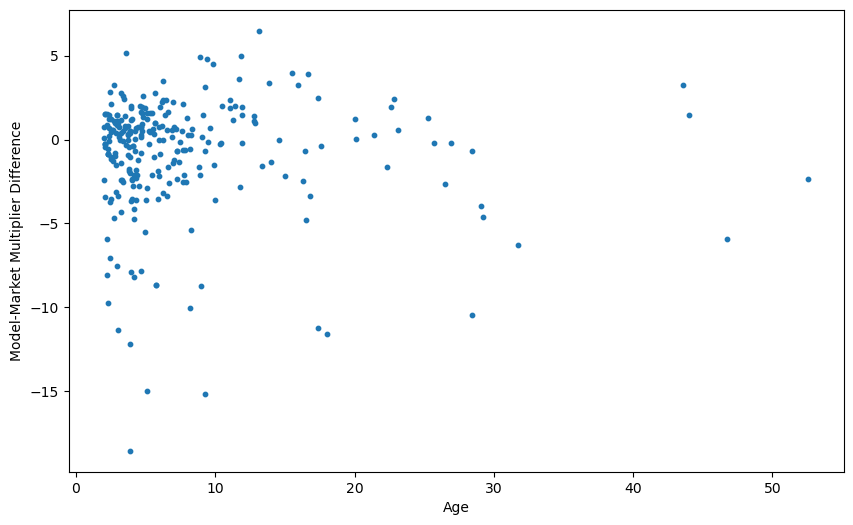

In [82]:
plt.figure(figsize=(10, 6))
plt.scatter(df_life2['age'], df_life2['model_multiplier'] - df_life2['multiplier'], s=10) 
plt.xlabel('Age')
plt.ylabel('Model-Market Multiplier Difference')
plt.savefig(f'./writeup/age_mmdifference_{suffix}.png', dpi=300)

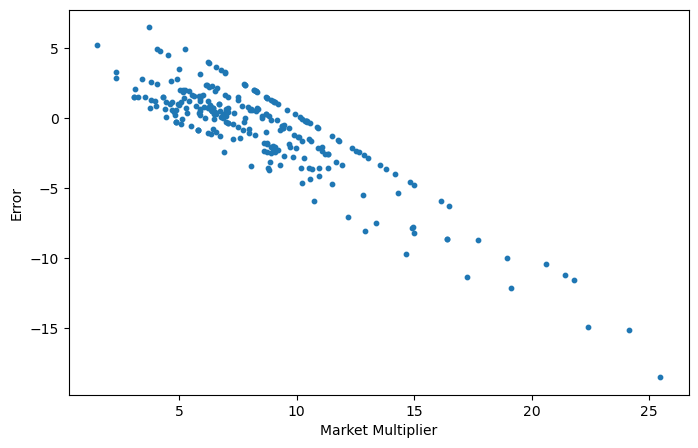

In [83]:
# plot of market multipler vs error
plt.figure(figsize=(8, 5))
plt.scatter(df_life2['multiplier'], (df_life2['model_multiplier'] - df_life2['multiplier']), s=10)
plt.xlabel('Market Multiplier')
plt.ylabel('Error')
plt.savefig(f'./writeup/market_diff_error_{suffix}.png', dpi=300)



In [84]:
df_life2['diff'] = df_life2['model_multiplier'] - df_life2['multiplier']
# select the deals with difference smaller than 1
df_life2[np.abs(df_life2['diff']) < 0.5][['name', 'age', 'discount_rate', 'model_multiplier', 'multiplier']]

,name,age,discount_rate,model_multiplier,multiplier
0,"Petty Too"" by Lil Durk - Songwriter Royalties""",2.06,0.106201,4.573018,4.85
3,"DaBaby, Jeremih, Justin Beiber and More Pop an...",4.20,0.121792,6.812680,6.77
4,"Rod Wave, Mozzy, Chris Brown + more - Songwrit...",5.22,0.116936,7.491584,7.75
9,"R&B Songwriter Royalties: Case, Mary J. Blige,...",25.72,0.095878,10.195055,10.43
18,"Blood All On It"" by Gucci Mane and More - Song...",2.39,0.111187,5.051432,5.13
26,"3LAU, Duke & Jones + More - Songwriting Royalties",2.38,0.118043,5.036967,4.84
30,NoMBe - Sound Recording Royalties,9.04,0.112509,8.991944,8.83
32,"Petty Too"" by Lil Durk - Songwriter Royalties""",2.06,0.106201,4.573018,4.85
40,Producer Royalties from Hip-Hop Artist NF,3.84,0.120115,6.922693,6.53
48,"D Rose"" by Lil Pump - Publishing Royalties""",7.44,0.109917,8.744021,8.91
